# N-Beats basics (PyTorch)
https://github.com/philipperemy/n-beats

https://arxiv.org/pdf/1905.10437.pdf (180 models ensembled in this paper with different backcast, loss and seed to beat M4 winner model)

Univariate Time Series (sales) predicted with N-Beats (forecast=28 days, backcast=3x28 days). Result is far away from simple LGB. Some model and hyperparameters tuning needs to be done. Feel free to fork and improve it.

- v1.0: 3 N-BEATS models with different backcast
- v1.1: Add first sales and cleaning
- v1.2: Adam/0.001, **LB=1.791 **,
  stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.GENERIC_BLOCK],
  thetas_dims=[2, 8, 3],
  nb_blocks_per_stack=3,
  hidden_layer_units=1024,
  share_weights_in_stack=False
- v1.3: Adam/0.001, **LB=1.076 **,
  stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
  thetas_dims=[4, 4],
  nb_blocks_per_stack=2,
  hidden_layer_units=1024,
  share_weights_in_stack=True
- v1.4: Adam/0.001, **LB=1.119 **,
  stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
  thetas_dims=[4, 4, 4],
  nb_blocks_per_stack=3,
  hidden_layer_units=1024,
  share_weights_in_stack=True  
- v1.5: Adam/0.001, **LB= **,
  stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
  thetas_dims=[8, 8],
  nb_blocks_per_stack=3,
  hidden_layer_units=1024,
  share_weights_in_stack=True    
  
  

In [42]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ll0406","key":"fa4830570075c294db90b927a8ca9fe8"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ll0406","key":"fa4830570075c294db90b927a8ca9fe8"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c m5-forecasting-accuracy
!mkdir '/content/data'

!unzip -qo 'm5-forecasting-accuracy.zip' -d '/content/data'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists
m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


In [43]:
import os, sys, random, gc, math, glob, time
import numpy as np
import pandas as pd
import io, timeit, os, gc, pickle, psutil
import joblib
from matplotlib import cm
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
from functools import partial
from collections import OrderedDict

# warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 4000)

In [44]:
seed = 2020
random.seed(seed)
np.random.seed(seed)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
DEFAULT_FIG_WIDTH = 20
sns.set_context("paper", font_scale=1.2) 

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict


print('Python    : ' + sys.version.split('\n')[0])
print('Numpy     : ' + np.__version__)
print('Pandas    : ' + pd.__version__)

Python    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Numpy     : 1.22.4
Pandas    : 1.5.3


In [47]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch import optim
from torch.optim import Adam, SGD
print('PyTorch        : ' + torch.__version__)

PyTorch        : 2.0.0+cu118


In [48]:
def seed_numpy_and_pytorch(s, sc):
    random.seed(s)
    os.environ['PYTHONHASHSEED'] = str(s)
    np.random.seed(s)
    # Torch
    torch.manual_seed(sc)
    torch.cuda.manual_seed(sc)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(sc)

seed_numpy_and_pytorch(seed, seed)

In [49]:
HOME =  "./"
DATA_HOME = "/content/data/"
TRAIN_DATA_HOME = DATA_HOME

CALENDAR = DATA_HOME + "calendar.csv"
SALES = DATA_HOME + "sales_train_validation.csv"
PRICES = DATA_HOME + "sell_prices.csv"
SAMPLE_SUBMISSION = DATA_HOME + "sample_submission.csv"

MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
           

Load data and remove days with no sales at the beginning.

In [50]:
train_sales_pd = pd.read_csv(SALES)
d_cols = [c for c in train_sales_pd.columns if 'd_' in c]
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']

grid_df = pd.melt(frame = train_sales_pd, 
                 id_vars = index_columns,
                 var_name = 'd',
                 value_vars = d_cols,
                 value_name = "sales")

grid_df["sales"] = grid_df["sales"].astype(np.float32)

In [51]:
train_prices_pd = pd.read_csv(PRICES)
# No price = Nothing to sell, find initial release date. It allows removing real leading zeros.
release_df = train_prices_pd.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']
# Now we can merge release_df
grid_df = pd.merge(left=grid_df, right=release_df, on=['store_id','item_id'], how='left')

In [52]:
train_calendar_pd = pd.read_csv(CALENDAR)
grid_df = pd.merge(left=grid_df, right=train_calendar_pd[['wm_yr_wk','d']], on=['d'], how="left")
# Now we can cutoff some rows and free memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)
grid_df.drop(columns=["release", "wm_yr_wk"], inplace=True)

Go back to column per-day format.

In [53]:
grid_df["d"] = grid_df["d"].apply(lambda x: x[2:])
grid_df["d"] = grid_df["d"].astype(np.int16)
grid_df = grid_df.sort_values(["id", "d"])
full_train_pd = grid_df.pivot(index='id', columns='d', values='sales')

In [54]:
full_train_pd.head()

d,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,3.0,0.0,0.0,1.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,1.0,7.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,7.0,1.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,6.0,3.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,

Check how much missing data.

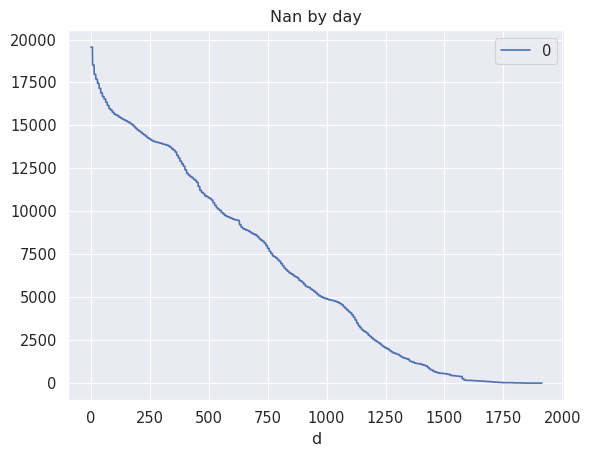

In [55]:
d = full_train_pd.isnull().sum().reset_index().plot(x="d")
d = plt.title("Nan by day")

In [56]:
del grid_df
gc.collect()

4045

In [57]:
# Clean data: remove leading zeros and outliers
# def clean_data(df_train, day_cols, indx):
#     t = df_train.loc[indx].copy()
#     t.loc[day_cols[((t.loc[day_cols]>0).cumsum()==0).values]] = np.nan
#     q1 = t.loc[day_cols].quantile(0.25)
#     q3 = t.loc[day_cols].quantile(0.75)
#     iqr = q3-q1
#     qm = (q3+1.5*iqr)
#     t.loc[day_cols][t.loc[day_cols]>qm] = qm
#     return t

For each time series, extract one day (backcast/forecast) randomly within full history. Fill in leading missing data (if any) with median. If no data available at all then assume it's zero.

In [58]:
def get_m5_data(backcast_length, forecast_length, df, is_training=True):
    x = np.array([]).reshape(0, backcast_length)
    y = np.array([]).reshape(0, forecast_length)
    x_tl_tl = df.values
    for i in range(x_tl_tl.shape[0]):
        if len(x_tl_tl[i]) < backcast_length + forecast_length:
            continue
        time_series = np.array(x_tl_tl[i])
        time_series_cleaned = time_series[~np.isnan(time_series)]
        if len(time_series_cleaned) < backcast_length + forecast_length:
            # Not enough data, fill missing value with median        
            median = np.nanmedian(time_series_cleaned) if len(time_series_cleaned) > 0 else 0.0
            missing_data = median * np.ones(((backcast_length + forecast_length)-time_series_cleaned.shape[0]))
            time_series_cleaned = np.concatenate([missing_data, time_series_cleaned])
        if is_training:
            time_series_cleaned_forlearning_x = np.zeros((1, backcast_length))
            time_series_cleaned_forlearning_y = np.zeros((1, forecast_length))
            # Random day within [140, 1886] i.e. 831 (if backcast = 140)
            j = np.random.randint(backcast_length, time_series_cleaned.shape[0] + 1 - forecast_length)
            # 140 backcast before random day
            time_series_cleaned_forlearning_x[0, :] = time_series_cleaned[j - backcast_length: j]
            # 28 forecast days after random day 691 <--> 831 <--> 859
            time_series_cleaned_forlearning_y[0, :] = time_series_cleaned[j:j + forecast_length]
        else:
            time_series_cleaned_forlearning_x = np.zeros(
                (time_series_cleaned.shape[0] + 1 - (backcast_length + forecast_length), backcast_length))
            time_series_cleaned_forlearning_y = np.zeros(
                (time_series_cleaned.shape[0] + 1 - (backcast_length + forecast_length), forecast_length))
            for j in range(backcast_length, time_series_cleaned.shape[0] + 1 - forecast_length):
                time_series_cleaned_forlearning_x[j - backcast_length, :] = time_series_cleaned[j - backcast_length:j]
                time_series_cleaned_forlearning_y[j - backcast_length, :] = time_series_cleaned[j: j + forecast_length]
        x = np.vstack((x, time_series_cleaned_forlearning_x))
        y = np.vstack((y, time_series_cleaned_forlearning_y))

    return x, y

In [59]:
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(self,
                 device,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 forecast_length=5,
                 backcast_length=10,
                 thetas_dims=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device
        print(f'| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(self.hidden_layer_units, self.thetas_dim[stack_id],
                                   self.device, self.backcast_length, self.forecast_length, self.nb_harmonics)
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linspace(backcast_length, forecast_length):
    lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
    b_ls = lin_space[:backcast_length]
    f_ls = lin_space[backcast_length:]
    return b_ls, f_ls


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(backcast_length, forecast_length)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

In [60]:
def split(arr, size):
    arrays = []
    while len(arr) > size:
        slice_ = arr[:size]
        arrays.append(slice_)
        arr = arr[size:]
    arrays.append(arr)
    return arrays


def batcher(dataset, batch_size, infinite=False):
    while True:
        x, y = dataset
        for x_, y_ in zip(split(x, batch_size), split(y, batch_size)):
            yield x_, y_
        if not infinite:
            break

In [61]:
def model_fit(net, optimiser, data_generator, on_save_callback, device, max_grad_steps=10000):
    train_loss = 0.0
    count = 0
    for grad_step, (x, target) in enumerate(data_generator):
        count = count + 1
        optimiser.zero_grad()
        net.train()
        backcast, forecast = net(torch.tensor(x, dtype=torch.float).to(device))
        loss = F.mse_loss(forecast, torch.tensor(target, dtype=torch.float).to(device))
        loss.backward()
        optimiser.step()
        train_loss = train_loss + loss.item()
        if grad_step > max_grad_steps:
            break
    return train_loss/count


def save(path, model, optimiser, grad_step):
    torch.save({
        #'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        #'optimizer_state_dict': optimiser.state_dict(),
    }, path)


def load(path, model, optimiser):
    if os.path.exists(path):
        grad_step = 0
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        #optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        #grad_step = checkpoint['grad_step']
        print(f'Restored checkpoint from {path}.')
        return grad_step
    return 0

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 24
batch_size = 3049 # 15245 # 3049 # 10 # 6098 # 15245

In [63]:
# forecast_length = 28

# MODEL_NAMES= {
#     #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx2": forecast_length*2,
#     "NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx3": forecast_length*3,
#     #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx4": forecast_length*4,
#     #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx5": forecast_length*5,
# }
            
# for name, backcast_length in MODEL_NAMES.items():
    
#     MODEL_PATH = HOME + "models/" + name
#     if not os.path.exists(MODEL_PATH):
#         os.makedirs(MODEL_PATH)
    
#     BEST_NAME = MODEL_PATH + "/best.pth"
    
#     print("Training:", MODEL_PATH)
#     val_cols = [c for c in range(1914-(backcast_length+forecast_length), 1914)]
#     val_pd = full_train_pd[[c for c in val_cols]]

#     test_cols = [c for c in range(1914-(backcast_length), 1914)]
#     test_pd = full_train_pd[[c for c in test_cols]]

#     train_cols = [c for c in range(1, 1914-(backcast_length+forecast_length))]
#     train_pd = full_train_pd[[c for c in train_cols]]     
    
#     # Validation data
#     X_val, y_val = get_m5_data(backcast_length, forecast_length, val_pd, is_training=False)

#     net = NBeatsNet(device=device,
#                     #stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.GENERIC_BLOCK],
#                     stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
#                     forecast_length=forecast_length,
#                     thetas_dims=[8, 8], # [2, 8, 3],
#                     nb_blocks_per_stack=3, #3,
#                     backcast_length=backcast_length,
#                     hidden_layer_units=1024,
#                     share_weights_in_stack=True, # False,
#                     nb_harmonics=None)

#     optimiser = optim.Adam(net.parameters(), lr=0.001)
    
#     best_score = 99999
#     total_steps = 0
#     loops = 3
#     history = []
#     for epoch in range(1, EPOCHS + 1):
#         print("Epoch:", epoch)
#         # Pick random range for each time series within [1-1745] days available
#         X_train, y_train = get_m5_data(backcast_length, forecast_length, train_pd, is_training=True)
#         max_grad_steps = int(X_train.shape[0]/batch_size) * loops
#         print("X_train:", X_train.shape, "y_train:", y_train.shape, "batches:", max_grad_steps)
#         #print("NaN X_train:", len(X_train[np.isnan(X_train)]), "NaN y_train:", len(y_train[np.isnan(y_train)]))

#         # Train all batches
#         data_gen = batcher((X_train, y_train), batch_size=batch_size, infinite=True)    
#         train_loss = model_fit(net, optimiser, data_gen, None, device, max_grad_steps)
#         total_steps = total_steps + max_grad_steps

#         # Evaluation
#         net.eval()
#         with torch.no_grad():
#             _, f = net(torch.tensor(X_val, dtype=torch.float))
#             predictions = f.cpu().numpy()
#             if len(predictions[np.isnan(predictions)]) == 0:
#                 score = mean_squared_error(y_val, predictions) # np.sqrt
#                 print("Training loss: %.5f, Evaluation loss: %.5f" % (train_loss, score))
#                 history.append((epoch, train_loss, score))
#                 if score < best_score:
#                     print("Saving model, score improvement from %.5f to %.5f" % (best_score, score))
#                     best_score = score
#                     save(BEST_NAME, net, optimiser, total_steps)
#             else:
#                 print("Some NaN predictions:", len(predictions[np.isnan(predictions)]), "train_loss:", train_loss)
                
#     history_pd = pd.DataFrame(history[1:], columns=["epoch", "train_loss", "val_loss"])
#     fig, ax = plt.subplots(figsize=(24, 5))
#     d = history_pd.plot(kind="line", x="epoch", ax=ax) 
#     plt.show()
    
#     # Load best and predict
#     _ = load(BEST_NAME, net, optimiser)
#     net.eval()
#     with torch.no_grad():
#         _, f = net(torch.tensor(test_pd.values, dtype=torch.float))
#         predictions = f.cpu().numpy()
        
#     # Clean and save
#     predictions_pd = pd.DataFrame(predictions)
#     predictions_pd.index = test_pd.index
#     predictions_pd.columns = ["F%d" % c for c in range(1,29)]
#     for c in predictions_pd.columns:
#         predictions_pd[c] = np.where(predictions_pd[c] < 0, 0.0, predictions_pd[c])
#     predictions_pd = predictions_pd.reset_index()
#     # predictions_pd["id"] = predictions_pd["id"].astype(str) + "_validation"
#     # display(predictions_pd.head())
#     # print("NaN:", predictions_pd.isnull().sum().sum())
#     predictions_pd.fillna(0, inplace=True)
#     submission = pd.read_csv(SAMPLE_SUBMISSION)[['id']]
#     submission = submission.merge(predictions_pd, on=['id'], how='left').fillna(0) # evaluation filled in with 0
#     submission.to_csv(MODEL_PATH + "/submission.csv.gz", index=False, compression="gzip")

In [64]:
# submission.head()

In [84]:
forecast_length = 28

name = "NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx3"
BEST_NAME = name
backcast_length = forecast_length*3

MODEL_NAMES= {
    #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx2": forecast_length*2,
    "NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx3": forecast_length*3,
    #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx4": forecast_length*4,
    #"NNv5_cv1_tss_Adam_2011-2016-N-BEATS_Hx5": forecast_length*5,
}
     

net = NBeatsNet(device=device,
                    #stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.GENERIC_BLOCK],
                    stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                    forecast_length=forecast_length,
                    thetas_dims=[8, 8], # [2, 8, 3],
                    nb_blocks_per_stack=3, #3,
                    backcast_length=backcast_length,
                    hidden_layer_units=1024,
                    share_weights_in_stack=True, # False,
                    nb_harmonics=None)
optimiser = optim.Adam(net.parameters(), lr=0.001)

# val_cols = [c for c in range(1914-(backcast_length+forecast_length), 1914)]
# val_pd = full_train_pd[[c for c in val_cols]]

test_cols = [c for c in range(1914-365-(backcast_length), 1914-365)]
test_pd = full_train_pd[[c for c in test_cols]]

# train_cols = [c for c in range(1, 1914-(backcast_length+forecast_length))]
# train_pd = full_train_pd[[c for c in train_cols]]   

# Load best and predict
_ = load('/nbeats.pth', net, optimiser)
net.eval()
with torch.no_grad():
    _, f = net(torch.tensor(test_pd.values, dtype=torch.float))
    predictions = f.cpu().numpy()


predictions_pd = pd.DataFrame(predictions)
predictions_pd.index = test_pd.index
predictions_pd.columns = ["F%d" % c for c in range(1,29)]
for c in predictions_pd.columns:
    predictions_pd[c] = np.where(predictions_pd[c] < 0, 0.0, predictions_pd[c])
predictions_pd = predictions_pd.reset_index()
# predictions_pd["id"] = predictions_pd["id"].astype(str) + "_validation"
# display(predictions_pd.head())
# print("NaN:", predictions_pd.isnull().sum().sum())
predictions_pd.fillna(0, inplace=True)

predictions_pd.iloc[321].tolist()[1:]


full_train_pd

def gen_forecast():
    forecast = []
    for t in reversed(range(1, 366)):
        X_cols = [c for c in range(1914-t-(backcast_length)-forecast_length, 1914-t-forecast_length)]
        X_pd = full_train_pd[[c for c in X_cols]]

        with torch.no_grad():
            _, f = net(torch.tensor(X_pd.values, dtype=torch.float))
            predictions = f.cpu().numpy()
        
        predictions_pd = pd.DataFrame(predictions)
        predictions_pd.index = X_pd.index
        predictions_pd.columns = ["F%d" % c for c in range(1,29)]
        for c in predictions_pd.columns:
            predictions_pd[c] = np.where(predictions_pd[c] < 0, 0.0, predictions_pd[c])
        predictions_pd = predictions_pd.reset_index()
    
        forecast.append(predictions_pd.iloc[25000].tolist()[1:])
    
    return forecast


forecast = gen_forecast()

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412422144
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412422144
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412422144
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412425984
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412425984
     | -- GenericBlock(units=1024, thetas_dim=8, backcast_length=84, forecast_length=28, share_thetas=False) at @139779412425984


In [85]:
predictions_pd.iloc[25000]

id     HOUSEHOLD_1_508_CA_1_validation
F1                                 0.0
F2                            0.728932
F3                                 0.0
F4                                 0.0
F5                            0.052804
F6                            0.153182
F7                                 0.0
F8                                 0.0
F9                            0.442703
F10                           0.196459
F11                           1.352536
F12                                0.0
F13                                0.0
F14                                0.0
F15                                0.0
F16                           1.215643
F17                           0.010755
F18                           0.867568
F19                           0.427891
F20                           0.690932
F21                                0.0
F22                           1.366106
F23                           0.111467
F24                                0.0
F25                      

In [86]:
X_cols = [c for c in range(1914-365-forecast_length, 1914-forecast_length)]
ACTUAL_SALES = full_train_pd[[c for c in X_cols]].iloc[25000].tolist()

In [87]:
from scipy.special import ndtri

class SingleItemSimulate:
    def __init__(self, demand, forecast, leadtime, desired_alpha=0.99):
        self.demand = demand
        self.forecast = forecast
        self.leadtime = leadtime

        self.inventory_points = []
        self.net_inventory = []
        self.wip_inventory = []
        self.orders = []

        self.forecast_err = []
        self.forecast_err_variation = 0
        self.forecast_err_exp_smooth_alpha = 0.8

        self.sim_duration = len(demand) - 28 

        self.desired_service_level = desired_alpha
        self.newsvendor_multiplier = ndtri(desired_alpha)

    def get_lead_time_forecasted_demand(self, t):
        """Get forecasted_demand at time t
        """
        forecast_at_t = self.forecast[t]
        lead_time_demand = sum(forecast_at_t[0:self.leadtime])
        return lead_time_demand
    
    def run(self):
        for t in range(0, self.sim_duration):
            # Calculate leadtime forecasted demand
            lead_time_forecasted_demand = self.get_lead_time_forecasted_demand(t)

            # Update forecast error if t >= leadtime
            if t >= self.leadtime:
                actual_past_leadtime_demand_t = sum(self.demand[t-self.leadtime:t])
                forecasted_past_leadtime_demand_t = sum(self.forecast[t-self.leadtime][0:self.leadtime])
                err = actual_past_leadtime_demand_t - forecasted_past_leadtime_demand_t
                self.forecast_err.append(np.abs(err))

                # Update forecast err variation use exponential smoothing
                previous_forecast_err_variation = self.forecast_err_variation
                current_forecast_err_std = np.std(self.forecast_err)
                self.forecast_err_variation = self.forecast_err_exp_smooth_alpha * current_forecast_err_std + (1-self.forecast_err_exp_smooth_alpha) * previous_forecast_err_variation
            
            # Calculate inventory point
            yesterday_inventory_point = 0 if t < 1 else self.inventory_points[t-1]
            yesterday_order = 0 if t < 1 else self.orders[t-1]
            today_inventory_point = yesterday_inventory_point + yesterday_order - self.demand[t]
            self.inventory_points.append(today_inventory_point)

            # Calculate order
            order = lead_time_forecasted_demand + self.forecast_err_variation * self.newsvendor_multiplier - self.inventory_points[t]
            self.orders.append(order)

            # Calculate net inventory and WIP inventory
            yesterday_net_inventory = 0 if t < 1 else self.net_inventory[t-1]
            last_leadtime_order = 0 if t < self.leadtime else self.orders[t-self.leadtime]
            net_inventory = yesterday_net_inventory + last_leadtime_order - self.demand[t]
            
            yesterday_wip_inventory = 0 if t < 1 else self.wip_inventory[t-1]
            wip_inventory = yesterday_wip_inventory + yesterday_order - last_leadtime_order

            self.net_inventory.append(net_inventory)
            self.wip_inventory.append(wip_inventory)

    def calculate_performance(self):
        """Calculate the performance metrics for the inventory operation
        """
        holding_cost = 0
        for ni in self.net_inventory:
            if ni > 0:
                holding_cost += ni
        order_variance = np.var(self.orders)
        achieved_service_level = 1 - float((np.array(self.net_inventory) < 0).sum()) / len(self.net_inventory)

        return holding_cost, order_variance, achieved_service_level




In [88]:
LEADTIMES = [5, 10, 15]
ALPHAS = [0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999]
RESULTS = {5: [], 10: [], 15: []}
for leadtime in LEADTIMES:
    for alpha in ALPHAS:
        simulate = SingleItemSimulate(ACTUAL_SALES, forecast, leadtime, desired_alpha=alpha)
        simulate.run()
        result = simulate.calculate_performance()
        RESULTS[leadtime].append(result)

print(RESULTS)

{5: [(204.05817207063816, 0.7281666899128473, 0.4599406528189911), (280.4200469312787, 0.7290899723932995, 0.5608308605341246), (410.2197591866921, 0.7311129267941776, 0.6320474777448071), (794.3846928783198, 0.739375232000533, 0.7833827893175074), (1114.4055920026958, 0.7484959379290753, 0.8456973293768546), (1393.6278229783093, 0.7579556136924508, 0.8753709198813057), (1645.3310313205825, 0.7675973373889912, 0.9109792284866469)], 10: [(278.36541928067186, 0.737767060529159, 0.3768545994065282), (368.54992817958686, 0.742321618719661, 0.4688427299703264), (532.4897082941072, 0.7495774303602539, 0.5637982195845697), (1036.9447658315391, 0.7711843159243208, 0.6646884272997033), (1447.802984447836, 0.7908784104222695, 0.7299703264094956), (1813.0553220800853, 0.8095591248072678, 0.798219584569733), (2149.05724402547, 0.8275850733565462, 0.8367952522255193)], 15: [(421.59519026080596, 0.7512339178761743, 0.3798219584569733), (531.7268626152506, 0.7554835744289896, 0.4540059347181009), (72

In [90]:
print(net)

NBeatsNet(
  (parameters): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1024x84 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 1024 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 1024x1024 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 1024 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 1024x1024 (GPU 0)]
      (5): Parameter containing: [torch.float32 of size 1024 (GPU 0)]
      (6): Parameter containing: [torch.float32 of size 1024x1024 (GPU 0)]
      (7): Parameter containing: [torch.float32 of size 1024 (GPU 0)]
      (8): Parameter containing: [torch.float32 of size 8x1024 (GPU 0)]
      (9): Parameter containing: [torch.float32 of size 8x1024 (GPU 0)]
      (10): Parameter containing: [torch.float32 of size 84x8 (GPU 0)]
      (11): Parameter containing: [torch.float32 of size 84 (GPU 0)]
      (12): Parameter containing: [torch.float32 of size 28x8 (GPU 0)]
      (13): Parameter con